# Find Location to Build New Movie Theater in Chennai, India

Capstone Project - The Battle of Neighborhoods


## Introduction 

#### Recommend a location in Chennai to open a new movie theatre.

My Client, the stakeholder wants to open a new cinema as his company's new business.

He explains that watching movie is a part of whole afternoon or night activities. Cinema should have many restaurants and shopping places nearby. Transportation is also an important factor. Customer can walk to cinema within 5 minutes from public transport facilities is perfect.

He wants me concentrated on selection of cinema location according to its nearby environment. Cinema facility and rental price is not my concern. He requested to compare against top favorite movie theatres with foursquare online traffic (tips & rating).

He selected 5 possible locations to build the cinema. Which location should be suggested to the stakeholder?

In [1]:
import pandas as pd 
possible_options = [
    { 'Options': 'Option1', 'Area': 'George Town, Chennai'},
    { 'Options': 'Option2', 'Area': 'Anna Nagar, Chennai'},
    { 'Options': 'Option3', 'Area': 'Nandanam, Chennai'},
    { 'Options': 'Option4', 'Area': 'Nungambakkam, Chennai'},
    { 'Options': 'Option5', 'Area': 'Saligramam, Chennai'},
]

df_possible_options = pd.DataFrame(possible_options, columns=['Options', 'Area'])
df_possible_options

,Options,Area
0,Option1,"George Town, Chennai"
1,Option2,"Anna Nagar, Chennai"
2,Option3,"Nandanam, Chennai"
3,Option4,"Nungambakkam, Chennai"
4,Option5,"Saligramam, Chennai"


# Data

According to the question, following data are required.

#### Geographic coordinate of Chennai movie theatres
I need to compare 5 possible locations with current cinemas in Chennai. Therefore, I need to find a list of Chennai movie theatre and it's geographic cordinates. I have extracted this data using Foursquare API, by search query 'Movie'. 

Here is the list of Movie theatres in Chennai,

In [2]:
# Import all the necessary packages & libraries

!pip install -U googlemaps
!pip install folium
!pip install geocoder
!pip install foursquare
import numpy as np 
import pandas as pd 
from bs4 import BeautifulSoup
from urllib.request import urlopen
import requests
import csv
import geocoder 
import folium
import geopy
import tqdm
from geopy.geocoders import Nominatim
import folium # map rendering library
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors
import json
from pandas.io.json import json_normalize
import googlemaps
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans
from scipy import stats
import seaborn as sns
from pathlib import Path
import os
import foursquare
%matplotlib inline

Requirement not upgraded as not directly required: requests<3.0,>=2.11.1 in /opt/conda/envs/DSX-Python35/lib/python3.5/site-packages (from googlemaps)
Requirement not upgraded as not directly required: chardet<3.1.0,>=3.0.2 in /opt/conda/envs/DSX-Python35/lib/python3.5/site-packages (from requests<3.0,>=2.11.1->googlemaps)
Requirement not upgraded as not directly required: idna<2.7,>=2.5 in /opt/conda/envs/DSX-Python35/lib/python3.5/site-packages (from requests<3.0,>=2.11.1->googlemaps)
Requirement not upgraded as not directly required: urllib3<1.23,>=1.21.1 in /opt/conda/envs/DSX-Python35/lib/python3.5/site-packages (from requests<3.0,>=2.11.1->googlemaps)
Requirement not upgraded as not directly required: certifi>=2017.4.17 in /opt/conda/envs/DSX-Python35/lib/python3.5/site-packages (from requests<3.0,>=2.11.1->googlemaps)
  Running setup.py bdist_wheel for googlemaps ... done
  Stored in directory: /home/dsxuser/.cache/pip/wheels/3c/3f/25/ce6d7722dba07e5d4a12d27ab38f3d7add65ef43171b

In [3]:
# The code was removed by Watson Studio for sharing.

In [4]:
# Get the Geographical cooridantes for Chennai from Geolocator 
address = 'Marina Beach, Chennai'

geolocator = Nominatim()
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geographical coordinate of Chennai are {}, {}.'.format(latitude, longitude))


# Setting the Venue Limits, radius & Serach quary as'Movie' for Chennai
LIMIT=500
radius=10000
query='Movie'
url = 'https://api.foursquare.com/v2/venues/explore?client_id={}&client_secret={}&ll={},{}&v={}&radius={}&limit={}&query={}'.format(CLIENT_ID, CLIENT_SECRET, latitude, longitude, VERSION, radius, LIMIT,query)

# Get the URL data in JSON format
results = requests.get(url).json()

# function that extracts the category of the venue
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

# Select the list of Movie theatres with it's geographical coordinates

venues = results['response']['groups'][0]['items']
    
nearby_venues = json_normalize(venues) # flatten JSON

# filter columns
filtered_columns = ['venue.name', 'venue.categories', 'venue.location.address','venue.location.lat', 'venue.location.lng', 'venue.id']
nearby_venues =nearby_venues.loc[:, filtered_columns]

# filter the category for each row
nearby_venues['venue.categories'] = nearby_venues.apply(get_category_type, axis=1)

# clean columns
nearby_venues.columns = [col.split(".")[-1] for col in nearby_venues.columns]
nearby_venues.dropna(inplace=True)
nearby_venues.reset_index(drop=True, inplace=True)

print('{} Movie Theatres were returned by Foursquare.'.format(nearby_venues.shape[0]))

nearby_venues.head()

The geographical coordinate of Chennai are 13.0518752, 80.2830143027039.
43 Movie Theatres were returned by Foursquare.


,name,categories,address,lat,lng,id
0,Escape Cinemas,Multiplex,Express Avenue,13.058746,80.264170,4c712b75f52cb71358fbb3af
1,Sathyam Cinemas,Movie Theater,"8, Thiru-vi-ka Road",13.055688,80.258096,4b7fba44f964a520073b30e3
2,Six Degree,Movie Theater,Sathyam Cinemas,13.055605,80.258115,4d4597f1e198721e2161c78b
3,Carve at Escape Cinemas,Movie Theater,Express Avenue,13.058681,80.264379,50080901e4b096ea743b677b
4,Devi Cineplex,Multiplex,Mount Road,13.066248,80.270877,517c1435e4b0a52325a8ee34


Marked the cinema theatres in Chennai Map

In [5]:
# create map of Manhattan using latitude and longitude values
map_chennai = folium.Map(location=[latitude, longitude], zoom_start=13)

# add markers to map
for lat, lng, label in zip(nearby_venues['lat'], nearby_venues['lng'], nearby_venues['name']):
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7).add_to(map_chennai)  
    
map_chennai

#### Geographic coordinates of 5 possible cinema addresses
Geographic coordinates of 5 possible cinemas are required and I can use Google Map API to find this information

In [6]:
# The code was removed by Watson Studio for sharing.

In [7]:
# Retrieve geolocation and create the dataframe of possible cinema addresses
def getLatLng(address):
    latlnt = gmaps.geocode('{}, Chennai'.format(address))
    return (latlnt[0]['geometry']['location']['lat'], latlnt[0]['geometry']['location']['lng'])

possible_locations = [
    { 'Options': 'Option1', 'Area': 'George Town, Chennai'},
    { 'Options': 'Option2', 'Area': 'Anna Nagar, Chennai'},
    { 'Options': 'Option3', 'Area': 'Nandanam, Chennai'},
    { 'Options': 'Option4', 'Area': 'Nungambakkam, Chennai'},
    { 'Options': 'Option5', 'Area': 'Saligramam, Chennai'},
]

for loc in possible_locations:   
    (lat, lng) = getLatLng(loc['Area'])
    loc['Latitude'] = lat
    loc['Longitude'] = lng
    
df_possible_options = pd.DataFrame(possible_locations, columns=['Options', 'Area', 'Latitude', 'Longitude'])
df_possible_options

,Options,Area,Latitude,Longitude
0,Option1,"George Town, Chennai",13.092316,80.282559
1,Option2,"Anna Nagar, Chennai",13.089136,80.209562
2,Option3,"Nandanam, Chennai",13.030105,80.241425
3,Option4,"Nungambakkam, Chennai",13.059537,80.242479
4,Option5,"Saligramam, Chennai",13.054605,80.199798


#### Get the list of Popular Movie theatres

By getting the ratings & tip counts for all the movie theatres, I can **use it as profile to select the best location**.

In [8]:
# Getting the Theatres ratings & Tip counts to determine the top theatres

appended_data=pd.DataFrame()
for VID in nearby_venues.id:
    VENUE_ID=VID
    url_venue_details = 'https://api.foursquare.com/v2/venues/{}?client_id={}&client_secret={}&v={}'.format(VENUE_ID,CLIENT_ID, CLIENT_SECRET,  VERSION)
    results_trending = requests.get(url_venue_details).json()
    items = results_trending['response']['venue']
    dataframe = json_normalize(items) # flatten JSON
    # filter columns
    filtered_columns = ['name', 'rating','tips.count','id',]
    dataframe_filtered = dataframe.loc[:, filtered_columns]
# clean column names
    dataframe_filtered.columns = [column.split('.')[0] for column in dataframe_filtered.columns]
    appended_data=appended_data.append(dataframe_filtered,ignore_index=True)
# see pd.concat documentation for more info

appended_data

/opt/conda/envs/DSX-Python35/lib/python3.5/site-packages/ipykernel/__main__.py:12: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
/opt/conda/envs/DSX-Python35/lib/python3.5/site-packages/pandas/core/indexing.py:1367: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)


,name,rating,tips,id
0,Escape Cinemas,9.2,112,4c712b75f52cb71358fbb3af
1,Sathyam Cinemas,9.3,197,4b7fba44f964a520073b30e3
2,Six Degree,7.6,3,4d4597f1e198721e2161c78b
3,Carve at Escape Cinemas,7.2,1,50080901e4b096ea743b677b
4,Devi Cineplex,6.9,4,517c1435e4b0a52325a8ee34
5,Inox Movies,6.5,33,4b5abef5f964a52008d328e3
6,Seasons,6.5,3,52b01cb6498e741b07bfc9d4
7,Albert Theatre,6.6,4,4dbab0aacda173a95d1e3bda
8,Palazzo,8.8,17,565c25ab498edac8bf2a58c2
9,Screen 4 @ Inox,NaN,0,4fa52a92e4b0ed0281c54d2a


Merging with original list

In [9]:
theatres_merged=nearby_venues.merge(appended_data,on=['name','id'])
theatres_merged.sort_values(by='tips',ascending=False,inplace=True)
theatres_merged.reset_index(drop=True, inplace=True)
theatres_merged.drop(columns=['categories','id'], inplace=True)
theatres_merged.head()

,name,address,lat,lng,rating,tips
0,Sathyam Cinemas,"8, Thiru-vi-ka Road",13.055688,80.258096,9.3,197
1,Escape Cinemas,Express Avenue,13.058746,80.264170,9.2,112
2,Luxe Cinemas,Phoenix Market City,12.991041,80.216962,8.8,96
3,PVR,Ampa Skywalk Mall,13.073799,80.221392,7.0,66
4,S2 Cinemas,"L.B. Road,",12.989660,80.256037,6.5,51


In [10]:
top_theatres=theatres_merged[(theatres_merged['tips']>50) | ((theatres_merged['rating']>7) & (theatres_merged['tips']>10)) ]
top_theatres.drop(columns=['address','lat','lng'], inplace=True)
top_theatres.reset_index(inplace=True,drop=True)
top_theatres

/opt/conda/envs/DSX-Python35/lib/python3.5/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


,name,rating,tips
0,Sathyam Cinemas,9.3,197
1,Escape Cinemas,9.2,112
2,Luxe Cinemas,8.8,96
3,PVR,7.0,66
4,S2 Cinemas,6.5,51
5,Palazzo,8.8,17


#### 4. Eating, Shopping and Public transportation facility around cinema
The recommended cinema location needs to have many eating and shopping venues nearby. Convenient public transport is also required.  
These data can be found by using FourSquare API to find these venues around the location. The radius of exploration distance is set to 1000 meters, which is about 10 minutes walking distance.

Following type of venue category will be used to search

In [11]:
fs_categories = {
    'Restaurant',
    'College',
    'Bus Stop',
    'Coffee',
    'Juice',
    'Food'
}
', '.join([ cat for cat in fs_categories])

'Coffee, College, Bus Stop, Food, Restaurant, Juice'

In [12]:
cinema = theatres_merged.loc[0]
print('Use the first cinema "{}" in the list as example to explore venues nearby'.format(cinema['name']))

Use the first cinema "Sathyam Cinemas" in the list as example to explore venues nearby


In [13]:
RADIUS = 1000 #1000 Metres
fs = foursquare.Foursquare(client_id=CLIENT_ID, client_secret=CLIENT_SECRET)

# Define a function to search nearby information and convert the result as dataframe
def venues_nearby(latitude, longitude, category, verbose=True):    
    results = fs.venues.search(
        params = {
            'query': category, 
            'll': '{},{}'.format(latitude, longitude),
            'radius': RADIUS,
        }
    )    
    df = json_normalize(results['venues'])
    cols = ['Name','Latitude','Longitude']    
    if( len(df) == 0 ):        
        df = pd.DataFrame(columns=cols)
    else:        
        df = df[['name','location.lat','location.lng']]
        df.columns = cols
    if( verbose ):
        print('{} "{}" venues are found within {}m of location'.format(len(df), category, RADIUS))
    return df
    

Find Restaurant around the cinema

In [14]:
venues_nearby(cinema['lat'], cinema['lng'], 'Restaurant').head()

30 "Restaurant" venues are found within 1000m of location


,Name,Latitude,Longitude
0,Sowbakiya Fast Food & Restaurant,13.057573,80.262873
1,Krishna Restaurant - Woodlands,13.045185,80.262107
2,Kurinchi restaurant,13.050201,80.262098
3,مطعم الزيتون Zaitoon restaurant,13.059848,80.251993
4,Sea Shell Family Restaurant,13.057127,80.255069


Find Bus Stop around the cinema

In [15]:
venues_nearby(cinema['lat'], cinema['lng'], 'Bus Stop').head()

20 "Bus Stop" venues are found within 1000m of location


,Name,Latitude,Longitude
0,Thousand Light Bus Stop,13.056020,80.255940
1,Thousand Light Mosque Bus Stop,13.054891,80.254884
2,Royapettah Police Station Bus Stop,13.051099,80.263225
3,Semmozhi Poonga Bus Stop,13.050546,80.252385
4,Gemini Bus Stop,13.052785,80.250697


Find Colleges around the cinema

In [16]:
venues_nearby(cinema['lat'], cinema['lng'], 'college').head()

21 "college" venues are found within 1000m of location


,Name,Latitude,Longitude
0,New College,13.053608,80.260541
1,Meston College of Education,13.058036,80.263504
2,Ethiraj College For Women,13.063878,80.259383
3,college side juice shop,13.054087,80.261276
4,"Indian Overseas Bank, The New College",13.055510,80.259561


Find Juice shops around the cinema

In [17]:
venues_nearby(cinema['lat'], cinema['lng'], 'juice').head()

10 "juice" venues are found within 1000m of location


,Name,Latitude,Longitude
0,Booster Juice,13.058705,80.264324
1,Juice Park,13.055748,80.257695
2,Jus Booster Juice,13.057454,80.260922
3,college side juice shop,13.054087,80.261276
4,"Bharath Petrol Bunk, In N Out, juice Stall",13.049566,80.252951


Find Coffee shops around the cinema

In [18]:
venues_nearby(cinema['lat'], cinema['lng'], 'coffee').head()

19 "coffee" venues are found within 1000m of location


,Name,Latitude,Longitude
0,Coffee Day Lounge,13.060967,80.251423
1,Coffee Shop,13.067088,80.258744
2,Café Coffee Day,13.056047,80.258423
3,Coffee day square,13.060946,80.250136
4,Madras Coffee House,13.056873,80.253495


## Methodology 

Methodology section which represents the main component of the report where you discuss and d
escribe any exploratory data analysis that you did, any inferential statistical testing that you performed, and what machine learnings were used and why.

With above data, I can use content-based recommendation technique to resolve the problem.

Combine with FourSquare API which provides how many venues in different category of Chennai theatres, a matrix which captured characteristic of venues nearby cinema are built. Popular theatres list is the profile to combine with the matrix to become a weighted matrix of favorite cinema.

The weighted matrix can be applied on 5 target locations with venues information to generate a ranking result. The the top one on the ranking list can be recommended to the stakeholder.

Before building the matrix, I have to prepare the required data and apply some data analysis.

#### Data Cleansing and Preparation
Check the cinemas dataset contains any duplicated address

In [19]:
duplicated = theatres_merged.duplicated('address', keep=False)
theatres_merged[duplicated].sort_values('address')

,name,address,lat,lng,rating,tips
1,Escape Cinemas,Express Avenue,13.058746,80.264170,9.2,112
32,Carve at Escape Cinemas,Express Avenue,13.058681,80.264379,7.2,1
2,Luxe Cinemas,Phoenix Market City,12.991041,80.216962,8.8,96
24,IMAX®,Phoenix Market City,12.990639,80.216310,7.6,3
20,Six Degree,Sathyam Cinemas,13.055605,80.258115,7.6,3
22,Seasons,Sathyam Cinemas,13.055444,80.257860,6.5,3
41,Santham,Sathyam Cinemas,13.055136,80.258913,NaN,0
42,Studio 5,Sathyam Cinemas,13.055472,80.257928,NaN,0


In [20]:
theatres_merged.drop_duplicates('address', inplace=True, keep='first')
print(theatres_merged.shape)
theatres_merged

(38, 6)


,name,address,lat,lng,rating,tips
0,Sathyam Cinemas,"8, Thiru-vi-ka Road",13.055688,80.258096,9.3,197
1,Escape Cinemas,Express Avenue,13.058746,80.264170,9.2,112
2,Luxe Cinemas,Phoenix Market City,12.991041,80.216962,8.8,96
3,PVR,Ampa Skywalk Mall,13.073799,80.221392,7.0,66
4,S2 Cinemas,"L.B. Road,",12.989660,80.256037,6.5,51
5,Inox Movies,"3rd Floor, Chennai Citi Centre, Dr. Radhakrish...",13.043144,80.273882,6.5,33
6,AGS Royal Cinemas,Villivakkam,13.104725,80.208934,4.9,26
7,S2 Cinemas,Perambur,13.112313,80.236524,6.8,20
8,Devi Cineplex,"48, Anna Salai",13.066325,80.270398,4.9,20
9,Sangam Cinemas,"870, Poonamallee High Road, Kilpauk, Near Hind...",13.078770,80.249352,5.8,19


Some cinemas are repated as a new cinema in  Foursquare.
These records are duplicated in my case and should be corrected.

In [21]:
# Sathyam Elite,Studio 5, satyam,Six Degree -> Sathyam Cinemas
theatres_merged.loc[theatres_merged['name'] == 'Six Degree', 'name'] = 'Sathyam Cinemas'
theatres_merged.loc[theatres_merged['name'] == 'satyam', 'name'] = 'Sathyam Cinemas'
theatres_merged.loc[theatres_merged['name'] == 'Sathyam Elite', 'name'] = 'Sathyam Cinemas'
theatres_merged.loc[theatres_merged['name'] == 'Studio 5', 'name'] = 'Sathyam Cinemas'

# Screen 4 @ Inox, Screen 4 -> Inox Movies
theatres_merged.loc[theatres_merged['name'] == 'Screen 4 @ Inox', 'name'] = 'Inox Movies'
theatres_merged.loc[theatres_merged['name'] == 'Screen 4', 'name'] = 'Inox Movies'

# Udhayam Theater -> Udhayam Theatre
theatres_merged.loc[theatres_merged['name'] == 'Udhayam Theater', 'name'] = 'Udhayam Theatre'

# Screen 6 @ Palazzo -> Palazzo
theatres_merged.loc[theatres_merged['name'] == 'Screen 6 @ Palazzo', 'name'] = 'Palazzo'


# AUDI 4 - PVR Cinemas -> PVR
theatres_merged.loc[theatres_merged['name'] == 'AUDI 4 - PVR Cinemas', 'name'] = 'PVR'

# Devi theaters -> Devi Cineplex
theatres_merged.loc[theatres_merged['name'] == 'Devi theaters', 'name'] = 'Devi Cineplex'

# Screen 2 @ S2 Cinemas, Screen 1 @ S2 Theyagaraja -> S2 Cinemas
theatres_merged.loc[theatres_merged['name'] == 'Screen 2 @ S2 Cinemas', 'name'] = 'S2 Cinemas'
theatres_merged.loc[theatres_merged['name'] == 'Screen 1 @ S2 Theyagaraja', 'name'] = 'S2 Cinemas'

In [22]:
duplicated = theatres_merged.duplicated('name', keep=False)
theatres_merged[duplicated].sort_values('name')

,name,address,lat,lng,rating,tips
21,Devi Cineplex,Mount road,13.066221,80.270418,5.7,3
8,Devi Cineplex,"48, Anna Salai",13.066325,80.270398,4.9,20
15,Devi Cineplex,Mount Road,13.066248,80.270877,6.9,4
5,Inox Movies,"3rd Floor, Chennai Citi Centre, Dr. Radhakrish...",13.043144,80.273882,6.5,33
35,Inox Movies,Citi Centre,13.043681,80.272669,NaN,0
33,Inox Movies,Paper Mills Rd,13.114077,80.236104,NaN,0
3,PVR,Ampa Skywalk Mall,13.073799,80.221392,7.0,66
31,PVR,PVR,13.073751,80.203702,NaN,1
11,Palazzo,Forum Vijaya Mall,13.050383,80.209541,8.8,17
39,Palazzo,Chennai,13.050430,80.209520,NaN,0


Drop the duplicated cinema records

In [23]:
theatres_merged.drop_duplicates('name', inplace=True, keep='first')
theatres_merged.reset_index(drop=True,inplace=True)
theatres_merged

,name,address,lat,lng,rating,tips
0,Sathyam Cinemas,"8, Thiru-vi-ka Road",13.055688,80.258096,9.3,197
1,Escape Cinemas,Express Avenue,13.058746,80.264170,9.2,112
2,Luxe Cinemas,Phoenix Market City,12.991041,80.216962,8.8,96
3,PVR,Ampa Skywalk Mall,13.073799,80.221392,7.0,66
4,S2 Cinemas,"L.B. Road,",12.989660,80.256037,6.5,51
5,Inox Movies,"3rd Floor, Chennai Citi Centre, Dr. Radhakrish...",13.043144,80.273882,6.5,33
6,AGS Royal Cinemas,Villivakkam,13.104725,80.208934,4.9,26
7,Devi Cineplex,"48, Anna Salai",13.066325,80.270398,4.9,20
8,Sangam Cinemas,"870, Poonamallee High Road, Kilpauk, Near Hind...",13.078770,80.249352,5.8,19
9,Abirami Mega Mall,Purasavakkam High Road,13.085900,80.248159,5.7,19


Check the shape of cinemas dataset

In [24]:
theatres_merged.shape

(24, 6)

Now I can use the FourSquare API to explore nearby venues of Chennai cinemas

In [25]:
venues_csv = Path('./cinemas_venues.csv')
df_venues = None

# check the venues data is explored and downloaded 
if( venues_csv.exists() ):
    os.remove('./cinemas_venues.csv')   
    
# construct a dataframe to store data
df_venues = pd.DataFrame(columns=['Cinema Name', 'Category', 'Name', 'Latitude', 'Longitude'])
for (name,  address, lat, lng,rating,tips) in theatres_merged.itertuples(index=False):
    for cat in fs_categories:
        df = venues_nearby(lat, lng, cat, verbose=False)
        df['Cinema Name'] = name
        df['Category'] = cat
        df_venues = df_venues.append(df)
df_venues.to_csv('cinemas_venues.csv', index=False)

In [26]:
print('Total {} of venues are found'.format(len(df_venues)))

Total 1128 of venues are found


In [27]:
df_venues.shape

(1128, 5)

In [28]:
# check some data
df_venues.head()

,Category,Cinema Name,Latitude,Longitude,Name
0,Coffee,Sathyam Cinemas,13.060967,80.251423,Coffee Day Lounge
1,Coffee,Sathyam Cinemas,13.067088,80.258744,Coffee Shop
2,Coffee,Sathyam Cinemas,13.056047,80.258423,Café Coffee Day
3,Coffee,Sathyam Cinemas,13.060946,80.250136,Coffee day square
4,Coffee,Sathyam Cinemas,13.056873,80.253495,Madras Coffee House


Number of venues in each category

In [29]:
df_venues['Category'].value_counts().to_frame(name='Count')

,Count
Restaurant,274
Food,216
Bus Stop,209
Coffee,164
Juice,139
College,126


Explore nearby venues of 5 possible/target locations

In [30]:
df_target_venues = pd.DataFrame(columns=['Options', 'Category', 'Name', 'Latitude', 'Longitude'])
for (location, area, latitude, longitude) in df_possible_options.itertuples(index=False):
    for cat in fs_categories:
        df = venues_nearby(latitude, longitude, cat, verbose=False)
        df['Options'] = location
        df['Category'] = cat
        df_target_venues = df_target_venues.append(df)

In [31]:
df_target_venues.head()

,Category,Latitude,Longitude,Name,Options
0,Coffee,13.088765,80.287796,Madras Coffee House,Option1
0,College,13.102566,80.285736,Bharti College for Women,Option1
1,College,13.084400,80.282400,Tamilnadu Government Dental college and Hospital,Option1
0,Bus Stop,13.087709,80.283508,Paris Bus Stop,Option1
1,Bus Stop,13.087841,80.283800,Broadway Bus Terminus,Option1


In [32]:
df_target_venues['Category'].value_counts().to_frame(name='Count')

,Count
Restaurant,70
Food,50
Bus Stop,47
Coffee,35
Juice,27
College,21


In [33]:
df_target_venues.shape

(250, 5)

I only interested in number of venues in each category of dataframe.

In [34]:
df_venues_count = df_venues.groupby(['Cinema Name','Category'], as_index=False).count()
df_venues_count.drop(columns=['Latitude','Longitude'], inplace=True)
df_venues_count.rename(columns={'Name':'Count'}, inplace=True)
df_venues_count.head()

,Cinema Name,Category,Count
0,AGS Navalur,Bus Stop,7
1,AGS Navalur,Coffee,8
2,AGS Navalur,College,2
3,AGS Navalur,Food,15
4,AGS Navalur,Juice,5


In [35]:
df_venues_count = df_venues_count.pivot(index='Cinema Name', columns='Category', values='Count').fillna(0)
df_venues_count.head()

Category,Bus Stop,Coffee,College,Food,Juice,Restaurant
Cinema Name,,,,,,
AGS Navalur,7.0,8.0,2.0,15.0,5.0,17.0
AGS Royal Cinemas,3.0,1.0,0.0,2.0,2.0,5.0
Abirami Mega Mall,7.0,4.0,4.0,7.0,6.0,7.0
Albert Theatre,5.0,7.0,1.0,10.0,6.0,21.0
Avm Rajeswari,9.0,10.0,1.0,9.0,7.0,8.0


Check the same for the possible locations

In [36]:
# Do the same process on target locations
df_target_venues_count = df_target_venues.groupby(['Options','Category']).size().reset_index(name='Count')
df_target_venues_count = df_target_venues_count.pivot(index='Options', columns='Category', values='Count').fillna(0)

In [37]:
df_target_venues_count

Category,Bus Stop,Coffee,College,Food,Juice,Restaurant
Options,,,,,,
Option1,7.0,1.0,2.0,4.0,5.0,10.0
Option2,8.0,11.0,5.0,18.0,6.0,23.0
Option3,5.0,5.0,3.0,8.0,3.0,15.0
Option4,17.0,13.0,11.0,10.0,8.0,16.0
Option5,10.0,5.0,0.0,10.0,5.0,6.0


#### Data Analysis
Check the data type of variables

In [38]:
df_venues_count.dtypes.to_frame(name='Data Type')

,Data Type
Category,
Bus Stop,float64
Coffee,float64
College,float64
Food,float64
Juice,float64
Restaurant,float64


All datatype is numeric

Generates descriptive statistics that summarize the central tendency,
dispersion and shape of a dataset's distribution

In [39]:
df_venues_count.describe()

Category,Bus Stop,Coffee,College,Food,Juice,Restaurant
count,24.000000,24.000000,24.000000,24.000000,24.000000,24.000000
mean,8.708333,6.833333,5.250000,9.000000,5.791667,11.416667
std,4.196056,4.018075,6.066659,4.075377,2.873858,7.156126
min,1.000000,0.000000,0.000000,2.000000,0.000000,0.000000
25%,6.000000,4.000000,1.000000,7.000000,4.000000,6.750000
50%,8.000000,7.000000,3.000000,9.000000,6.000000,10.000000
75%,11.250000,9.000000,7.000000,11.000000,8.000000,17.000000
max,20.000000,19.000000,21.000000,22.000000,11.000000,30.000000


Get the count of Bus stop

In [40]:
df_venues_count['Bus Stop'].value_counts().sort_index().to_frame('Cinema Count')

,Cinema Count
1.0,1
3.0,1
4.0,1
5.0,2
6.0,3
7.0,4
9.0,1
10.0,2
11.0,3
12.0,4


In [41]:
df_venues_count[df_venues_count['Bus Stop'] > 10]

Category,Bus Stop,Coffee,College,Food,Juice,Restaurant
Cinema Name,,,,,,
Escape Cinemas,11.0,10.0,18.0,10.0,9.0,17.0
Four Frames Preview Theatre,12.0,8.0,5.0,11.0,8.0,17.0
Ganapathyram A/C Dts,12.0,6.0,3.0,8.0,7.0,13.0
Inox Movies,12.0,7.0,7.0,11.0,4.0,16.0
Movie Club,11.0,10.0,7.0,22.0,5.0,17.0
Palazzo,11.0,9.0,2.0,11.0,11.0,9.0
S2 Cinemas,15.0,5.0,0.0,11.0,6.0,12.0
Sathyam Cinemas,20.0,19.0,21.0,13.0,10.0,30.0
Woodlands Theater,12.0,11.0,19.0,10.0,9.0,22.0


In [42]:
busstop_over_8 = df_venues_count[df_venues_count['Bus Stop'] > 2].index.tolist()
df_venues[(df_venues['Cinema Name'].isin(busstop_over_8)) & (df_venues.Category == 'Bus Stop')]

,Category,Cinema Name,Latitude,Longitude,Name
0,Bus Stop,Sathyam Cinemas,13.056020,80.255940,Thousand Light Bus Stop
1,Bus Stop,Sathyam Cinemas,13.054891,80.254884,Thousand Light Mosque Bus Stop
2,Bus Stop,Sathyam Cinemas,13.051099,80.263225,Royapettah Police Station Bus Stop
3,Bus Stop,Sathyam Cinemas,13.050546,80.252385,Semmozhi Poonga Bus Stop
4,Bus Stop,Sathyam Cinemas,13.052785,80.250697,Gemini Bus Stop
5,Bus Stop,Sathyam Cinemas,13.061514,80.263557,LIC Bus Stop
6,Bus Stop,Sathyam Cinemas,13.054950,80.249356,I.O.C Bus Stop
7,Bus Stop,Sathyam Cinemas,13.055736,80.255630,Bus 18K
8,Bus Stop,Sathyam Cinemas,13.054174,80.253710,Mountroad Bus Stand
9,Bus Stop,Sathyam Cinemas,13.058563,80.264359,Pit Stop


Venue 'Thousand Light Mosque Bus Stop' & Vadapalani Bus Stand is duplicated and should be removed.

In [43]:
df_venues = df_venues[df_venues.Name != 'Thousand Light Mosque Bus Stop']
df_venues = df_venues[df_venues.Name != 'Vadapalani Bus Stand']


In [44]:
busstop_over_8 = df_venues_count[df_venues_count['Bus Stop'] > 2].index.tolist()
df_venues[(df_venues['Cinema Name'].isin(busstop_over_8)) & (df_venues.Category == 'Bus Stop')]

,Category,Cinema Name,Latitude,Longitude,Name
0,Bus Stop,Sathyam Cinemas,13.056020,80.255940,Thousand Light Bus Stop
2,Bus Stop,Sathyam Cinemas,13.051099,80.263225,Royapettah Police Station Bus Stop
3,Bus Stop,Sathyam Cinemas,13.050546,80.252385,Semmozhi Poonga Bus Stop
4,Bus Stop,Sathyam Cinemas,13.052785,80.250697,Gemini Bus Stop
5,Bus Stop,Sathyam Cinemas,13.061514,80.263557,LIC Bus Stop
6,Bus Stop,Sathyam Cinemas,13.054950,80.249356,I.O.C Bus Stop
7,Bus Stop,Sathyam Cinemas,13.055736,80.255630,Bus 18K
8,Bus Stop,Sathyam Cinemas,13.054174,80.253710,Mountroad Bus Stand
9,Bus Stop,Sathyam Cinemas,13.058563,80.264359,Pit Stop
10,Bus Stop,Sathyam Cinemas,13.057406,80.256994,UX Business Solutions


Re-construct the dataframe again

In [45]:
df_venues_count = df_venues.groupby(['Cinema Name','Category'], as_index=False).count()
df_venues_count.drop(columns=['Latitude','Longitude'], inplace=True)
df_venues_count.rename(columns={'Name':'Count'}, inplace=True)
df_venues_count = df_venues_count.pivot(index='Cinema Name', columns='Category', values='Count').fillna(0)
df_venues_count.head()

Category,Bus Stop,Coffee,College,Food,Juice,Restaurant
Cinema Name,,,,,,
AGS Navalur,7.0,8.0,2.0,15.0,5.0,17.0
AGS Royal Cinemas,3.0,1.0,0.0,2.0,2.0,5.0
Abirami Mega Mall,7.0,4.0,4.0,7.0,6.0,7.0
Albert Theatre,5.0,7.0,1.0,10.0,6.0,21.0
Avm Rajeswari,8.0,10.0,1.0,9.0,7.0,8.0


Plot the distribution of all the variables

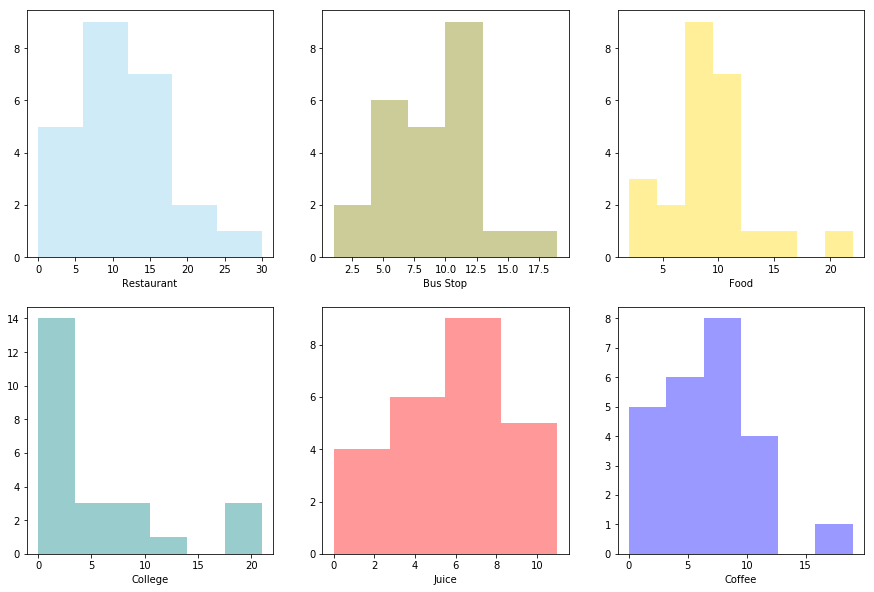

In [46]:
f, axes = plt.subplots(2,3, figsize=(15, 10))
sns.distplot(df_venues_count['Restaurant'] , color="skyblue", ax=axes[0, 0], kde=False)
sns.distplot(df_venues_count['Bus Stop'] , color="olive", ax=axes[0, 1], kde=False)
sns.distplot(df_venues_count['Food'] , color="gold", ax=axes[0,2], kde=False)
sns.distplot(df_venues_count['College'] , color="teal", ax=axes[1, 0], kde=False)
sns.distplot(df_venues_count['Juice'] , color="red", ax=axes[1, 1], kde=False)
sns.distplot(df_venues_count['Coffee'] , color="blue", ax=axes[1, 2], kde=False)

The distribution of other variables are quite similar. Now check their Pearson Correlation

In [47]:
df_venues_count.corr()

Category,Bus Stop,Coffee,College,Food,Juice,Restaurant
Category,,,,,,
Bus Stop,1.000000,0.712231,0.518184,0.574541,0.526192,0.649852
Coffee,0.712231,1.000000,0.699183,0.615991,0.546583,0.763099
College,0.518184,0.699183,1.000000,0.298954,0.494391,0.620420
Food,0.574541,0.615991,0.298954,1.000000,0.389788,0.642545
Juice,0.526192,0.546583,0.494391,0.389788,1.000000,0.465282
Restaurant,0.649852,0.763099,0.620420,0.642545,0.465282,1.000000


It seems that 'Bus Stop' & 'Coffee' category are highly correlated.  
Find **P-Value** of the variables

By convention, when the p-value is:
- < 0.001 we say there is strong evidence that the correlation is significant,
- < 0.05; there is moderate evidence that the correlation is significant,
- < 0.1; there is weak evidence that the correlation is significant, and
- is >  0.1; there is no evidence that the correlation is significant.

In [48]:
p_value_data = []
for left in df_venues_count.columns:
    p_values = [left]
    for right in df_venues_count.columns:        
        pearson_coef, p_value = stats.pearsonr(df_venues_count[left], df_venues_count[right])
        if(p_value < 0.001):
            p_values.append('strong')
        elif(p_value < 0.05):
            p_values.append('moderate')
        elif(p_value < 0.1):
            p_values.append('weak')
        else:
            p_values.append('no')            
    p_value_data.append(p_values)

In [49]:
df_p_values = pd.DataFrame(p_value_data, columns=['Category'] + df_venues_count.columns.tolist())

In [50]:
df_p_values

,Category,Bus Stop,Coffee,College,Food,Juice,Restaurant
0,Bus Stop,strong,strong,moderate,moderate,moderate,strong
1,Coffee,strong,strong,strong,moderate,moderate,strong
2,College,moderate,strong,strong,no,moderate,moderate
3,Food,moderate,moderate,no,strong,weak,strong
4,Juice,moderate,moderate,moderate,weak,strong,moderate
5,Restaurant,strong,strong,moderate,strong,moderate,strong


The correlation between 'Bus Stop', 'Coffee', 'Restaurant' are statistically significant, and the coefficient of > 0.5 shows that the relationship is positive

In [51]:
top_theatres

,name,rating,tips
0,Sathyam Cinemas,9.3,197
1,Escape Cinemas,9.2,112
2,Luxe Cinemas,8.8,96
3,PVR,7.0,66
4,S2 Cinemas,6.5,51
5,Palazzo,8.8,17



**Visualize the location of cinemas, target location and stakeholder's favorite cineams on the map**

In [52]:
Chennai_coords = getLatLng('Chennai')

In [53]:
Chennai_map = folium.Map(location=Chennai_coords, zoom_start=13)

cinemas_fg = folium.FeatureGroup()
targets_fg = folium.FeatureGroup()
top_fg = folium.FeatureGroup()

for(location, address, latitude, longitude) in df_possible_options.itertuples(index=False):
    targets_fg.add_child(
        folium.CircleMarker(
            location=(latitude, longitude),
            popup=location,
            radius=7,
            fill=True,
            color='green',
            fill_opacity=1.
        )
    )

    
top_theatres_rating = top_theatres.set_index('name')    
name_list = top_theatres_rating.index.tolist()

for (name, address, latitude, longitude,  rating, tips ) in theatres_merged.itertuples(index=False):    
    
    color = 'blue'        
    popup = name
    
    if( name in name_list ):
        color = 'red'    
        popup = '{} - Rating: {} : TipCount: {}'.format(name, top_theatres_rating.loc[name,'rating'], top_theatres_rating.loc[name,'tips'])
        
    cinemas_fg.add_child(        
        folium.CircleMarker(
            location=(latitude, longitude),
            popup=popup,
            radius=5,
            fill=True,
            color=color,
            fill_opacity=1.
        )
    )
    
Chennai_map.add_child(cinemas_fg)
Chennai_map.add_child(targets_fg)

Most of Chennai movie theatres (blue circle) and popular cinemas (red circle) location are built near main road, and centralized in urban area of Chennai. The target locations (green circle) of new cinema.

#### Machine Learning

Now, let's use __Content-Based__ or __Item-Item recommendation systems__. In this case, I am going to try to figure out the new cinema location by counting number of nearby venues and ratings given.

Normalize the values of venues dataframe by using MinMaxScaler method

In [54]:
df_venues_count.head()

Category,Bus Stop,Coffee,College,Food,Juice,Restaurant
Cinema Name,,,,,,
AGS Navalur,7.0,8.0,2.0,15.0,5.0,17.0
AGS Royal Cinemas,3.0,1.0,0.0,2.0,2.0,5.0
Abirami Mega Mall,7.0,4.0,4.0,7.0,6.0,7.0
Albert Theatre,5.0,7.0,1.0,10.0,6.0,21.0
Avm Rajeswari,8.0,10.0,1.0,9.0,7.0,8.0


In [55]:
scaler = MinMaxScaler()

In [56]:
venues_normalized = scaler.fit_transform(df_venues_count)

In [57]:
df_venues_normalized = pd.DataFrame(
    venues_normalized,
    index=df_venues_count.index,
    columns=df_venues_count.columns
)

In [58]:
df_venues_normalized.head()

Category,Bus Stop,Coffee,College,Food,Juice,Restaurant
Cinema Name,,,,,,
AGS Navalur,0.333333,0.421053,0.095238,0.65,0.454545,0.566667
AGS Royal Cinemas,0.111111,0.052632,0.000000,0.00,0.181818,0.166667
Abirami Mega Mall,0.333333,0.210526,0.190476,0.25,0.545455,0.233333
Albert Theatre,0.222222,0.368421,0.047619,0.40,0.545455,0.700000
Avm Rajeswari,0.388889,0.526316,0.047619,0.35,0.636364,0.266667


Merge the data with top theates list

In [59]:
top_theatres_ratings_table = pd.merge(
    top_theatres,
    df_venues_normalized,
    how='inner',
    left_on='name',
    right_index=True
)
top_theatres_ratings_table.drop(['name','rating','tips'], axis=1, inplace=True)
top_theatres_ratings_table

,Bus Stop,Coffee,College,Food,Juice,Restaurant
0,1.000000,1.000000,1.000000,0.55,0.909091,1.000000
1,0.500000,0.526316,0.857143,0.40,0.818182,0.566667
2,0.277778,0.473684,0.095238,0.25,0.272727,0.333333
3,0.277778,0.315789,0.238095,0.20,0.545455,0.100000
4,0.777778,0.263158,0.000000,0.45,0.545455,0.400000
5,0.500000,0.473684,0.095238,0.45,1.000000,0.300000


Dot product to get the weight of rating on each category according to top theatres

In [60]:
top_profile = top_theatres_ratings_table.transpose().dot(top_theatres['rating'])

In [61]:
top_profile

Bus Stop      27.744444
Coffee        26.400000
College       20.528571
Food          19.280000
Juice         34.545455
Restaurant    23.386667
dtype: float64

Normalize the values of target venues

In [62]:
df_targets_normalized = pd.DataFrame(
    scaler.transform(df_target_venues_count),
    index=df_target_venues_count.index,
    columns=df_target_venues_count.columns
)

In [63]:
df_targets_normalized

Category,Bus Stop,Coffee,College,Food,Juice,Restaurant
Options,,,,,,
Option1,0.333333,0.052632,0.095238,0.1,0.454545,0.333333
Option2,0.388889,0.578947,0.238095,0.8,0.545455,0.766667
Option3,0.222222,0.263158,0.142857,0.3,0.272727,0.500000
Option4,0.888889,0.684211,0.523810,0.4,0.727273,0.533333
Option5,0.500000,0.263158,0.000000,0.4,0.454545,0.200000


## Results

Results section where you discuss the results.

With the top movie theatres and the complete list of cinemas and their venues count in hand, I am going to take the weighted average of every location based on the profile and recommend the top location that most satisfy it.

In [64]:
df_recommend = (df_targets_normalized*top_profile).sum(axis=1)/top_profile.sum()
df_recommend = df_recommend.reset_index(name='Rating')

In [65]:
df_possible_options

,Options,Area,Latitude,Longitude
0,Option1,"George Town, Chennai",13.092316,80.282559
1,Option2,"Anna Nagar, Chennai",13.089136,80.209562
2,Option3,"Nandanam, Chennai",13.030105,80.241425
3,Option4,"Nungambakkam, Chennai",13.059537,80.242479
4,Option5,"Saligramam, Chennai",13.054605,80.199798


In [66]:
df_final = pd.merge(
    df_possible_options,
    df_recommend,
    left_on='Options',
    right_on='Options'
)
df_final.sort_values('Rating', ascending=False, inplace=True)

In [67]:
df_final

,Options,Area,Latitude,Longitude,Rating
3,Option4,"Nungambakkam, Chennai",13.059537,80.242479,0.650405
1,Option2,"Anna Nagar, Chennai",13.089136,80.209562,0.547507
4,Option5,"Saligramam, Chennai",13.054605,80.199798,0.322029
2,Option3,"Nandanam, Chennai",13.030105,80.241425,0.282742
0,Option1,"George Town, Chennai",13.092316,80.282559,0.250313


In [68]:
print('I should recommend the location "{}" of area "{}" to the stakeholder'.format(df_final.iat[0,0], df_final.iat[0,1]))

I should recommend the location "Option4" of area "Nungambakkam, Chennai" to the stakeholder


The result is reasonable. Location '**Option4 - Nungambakkam**' has the most number of venues in category "Bus Stop", "College", "Coffee" and "Juice". 

In [69]:
df_target_venues_count.head()

Category,Bus Stop,Coffee,College,Food,Juice,Restaurant
Options,,,,,,
Option1,7.0,1.0,2.0,4.0,5.0,10.0
Option2,8.0,11.0,5.0,18.0,6.0,23.0
Option3,5.0,5.0,3.0,8.0,3.0,15.0
Option4,17.0,13.0,11.0,10.0,8.0,16.0
Option5,10.0,5.0,0.0,10.0,5.0,6.0


Moreover, these categories are most concerned by the stakeholder according to profile rating

In [70]:
top_profile.sort_values(ascending=False)

Juice         34.545455
Bus Stop      27.744444
Coffee        26.400000
Restaurant    23.386667
College       20.528571
Food          19.280000
dtype: float64

Therefore, Location "Option4 - Nungambakkam" should be recommeded to the stakeholder for the new movie theatre.

## Discussion

**Discussion section where you discuss any observations you noted and any recommendations you can make based on the results.**

Number of venues of 5 target locations are actually better than the average

Average count of venues in Chennai cinema location

In [71]:
df_venues_count.mean().to_frame(name='Average Count')

,Average Count
Category,
Bus Stop,8.500000
Coffee,6.833333
College,5.250000
Food,9.000000
Juice,5.791667
Restaurant,11.416667


Average count of venues in 5 target locations

In [72]:
df_target_venues_count.mean().to_frame('Average Count')

,Average Count
Category,
Bus Stop,9.4
Coffee,7.0
College,4.2
Food,10.0
Juice,5.4
Restaurant,14.0


I should contact local commercial property agents to find more suitable locations. Moreover, FourSquare is not popular in India, the data maybe out-dated or unreliable, the report should gather more data from other location data source such as Google Place API.

## Conclusion 

**Conclusion section where you conclude the report.**

The stakeholder's problem is resolved. Stakeholder wants to find the best place to build a new cinema in Chennai, India, and the factors of "best location" is based on the number of venues in eating, shopping, transportation category around the location. Stakeholder also provide his favorite list of cinema to further explain what the "best location" is. Content-based filtering machine learning technique is the most suitable method to resolve the problem. It combines stakeholder's preference and cinema profile to make the recommendation result.

The 5 target locations of new cinema may not be a good choices. Another key things to consider could be traffic & real estate value. As the weighting matrix is developed, I can quickly pick other locations and make the recommendation again.